In [30]:
import numpy as np
import datetime

from os import listdir
from os.path import isfile, join

import licel as licel
import generic as generic

from us_std import Atmosphere
import rayleigh_scattering as rscat

from scipy import signal
from scipy import integrate
from scipy import stats

import statsmodels.api as sm

import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot

%matplotlib notebook

In [31]:
def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

def fit(q0,q1,Sn,Sf):
    GCs = np.polyfit(Sn[q0:q1],Sf[q0:q1],1)
#   f = np.poly1d(GCs)
#   an_new = f(Sn[q0:q1])
    return GCs

def get_toggle_freq(an, an_d, pc, overlap, max_freq, min_freq = None, pre_amplifier_range = None, LSB_coeff = None):
#   tmp = np.subtract(an, an_d)
#   an = tmp[0]
    LSB = pre_amplifier_range/2.0**12
    Xa = None
    Xp = None
    min_freq_bin = None

    if min_freq == None and LSB == None:
        warnings.warn('No min_freq or LSB specified.')

    if LSB != None:
        if LSB_coeff == None:
            warnings.warn('LSB_coeff not specified. Using LSB_coeff = 2')
            LSB_coeff = 2.0
        for j in range(overlap, len(an)):
            if an[j] < LSB_coeff * LSB:
               Xa = j - 1
               break

    if min_freq != None:
        for j in range(overlap, len(pc)):
            if pc[j] < min_freq:
               min_freq_bin = j - 1
               break

    if max_freq > 70.0 or max_freq < 10.0:
        warnings.warn('Maximum toggle frerquency values between 10MHz and 70MHz are considered "safe" by Raymetrics')

    if np.amax(pc) > max_freq:
        for j in range(overlap, len(pc)):
            if pc[j] < max_freq:
                Xp = j - 1
                break
    else:
       warnings.warn('Specified maximum toggle frequency is greater than photon counting signal peak.')
    return (Xp, Xa, min_freq_bin)

In [32]:
dates = []

Taud = 4e-09
range_355 = 100.0
range_387 = 20.0
Xa355 = []
Xp355 = []
mfb355 = []
Xa387 = []
Xp387 = []
mfb387 = []
maxf = 10.0
overlap = 60
root_dir = '190221'
data_dir = root_dir+'/ray30'
dark_dir = root_dir+'/dark'
dark_file = [join(dark_dir, f) for f in listdir(dark_dir) if isfile(join(dark_dir,f))]
#print('dark_file=',dark_file)
dark_measurement = generic.LicelLidarMeasurement(dark_file)
an355d = dark_measurement.channels['00355.o_an'].matrix
ph355d = dark_measurement.channels['00355.o_ph'].matrix
an387d = dark_measurement.channels['00387.o_an'].matrix
ph387d = dark_measurement.channels['00387.o_ph'].matrix

filelist = [join(data_dir,f) for f in listdir(data_dir) if isfile(join(data_dir,f))]
filelist.sort()
#print(filelist,len(filelist))

In [33]:
measurement = generic.LicelLidarMeasurement(filelist)
    
an355 = measurement.channels['00355.o_an'].matrix 
ph355 = measurement.channels['00355.o_ph'].matrix
an387 = measurement.channels['00387.o_an'].matrix
ph387 = measurement.channels['00387.o_ph'].matrix

z = measurement.channels['00355.o_an'].z
valid_time = measurement.info['start_time'] + measurement.info['duration']/2 
dates.append(valid_time)

In [34]:
an = an387
ph = ph387
an_d = an387d
#Ns = 2.54743E19 #cm-3
Ns = 2.54743E25 #m-3
sigma355 = rscat.scattering_cross_section(355) * 1E-4
sigma387 = rscat.scattering_cross_section(387) * 1E-4
rhon355 = 0.0306
rhon387 = 0.0299
sigma = sigma387
rhon = rhon387

#dead time correction
nDTC = ph
nDTCa = np.mean(ph, axis = 0)
ph = ph*1000000.0/(1 - (ph*1000000.0*Taud))
ph = ph/1000000.0
#dark subtraction
an = an - an_d
#an387 = an387 - an387d

#gluing region
ana = np.mean(an, axis = 0)
pha = np.mean(ph, axis = 0)

#zero bin and bin shift
#ana = np.roll(ana, -7)
#pha = np.roll(pha, 2)
ana = np.roll(ana, -9)

#analog background correction
background = np.mean(ana[4000:6000])
ana = ana - background
#photon counting background correction
background = np.mean(pha[4000:6000])
pha = pha - background

Xp, Xa, mfb = get_toggle_freq(ana, an_d, pha, overlap, max_freq = 10.0, min_freq = 0.5, pre_amplifier_range = range_355, LSB_coeff = 2.0)
print('Xp, Xa, mfb')
print(Xp, Xa, mfb)

Xp, Xa, mfb
(76, 111, 271)


In [6]:
#======================standard atmosphere US1976=============================
T = []
p = []
hgt = []
rho = []
N = []
scat = []
ang_scat = []
a_mol = []
b_mol = []

T0 = 288.15 #K
p0 = 1013.25 #hPa
atm = Atmosphere(t_r = 283.5, p_r = 998.6, alt = 89.0)
#atm = Atmosphere(t_r = T0, p_r = p0, alt = 0.0)

for zz in my_range(89.0,84852,7.5):
    T.append(atm.temperature(zz))
    p.append(atm.pressure(zz))
    rho.append(atm.density(zz))
    hgt.append(zz)
    a_mol.append(sigma * Ns * (T0 / T[-1]) * (p[-1] / p0))
    b_mol.append((a_mol[-1] / (8.0*np.pi/3.0)) * (2 / (2 + rhon)))

hgt = np.asarray(hgt)
a_mol = np.asarray(a_mol)
b_mol = np.asarray(b_mol)

a_mol = a_mol
b_mol = b_mol

b_tmp = np.delete(b_mol,-1)
hgt_tmp = np.delete(hgt,-1)

In [39]:
#=========================radiosounding================================
data = np.genfromtxt(root_dir+'/rs.txt')
pRS, hgtRS, TRS, TdRS, RHRS = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
TRS = TRS + 273.15

hgtRS_int = np.linspace(210.0, 30210.0, 4001)
##hgtRS_int = np.linspace(0.0, 30210.0, 4029)
hgtRS_wt = np.linspace(0.0, 30210.0, 4029)
#print(hgtRS_int)
pRS_int = np.interp(hgtRS_int, hgtRS, pRS)
TRS_int = np.interp(hgtRS_int, hgtRS, TRS)
RHRS_int = np.interp(hgtRS_int, hgtRS, RHRS)
a_mol_RS = sigma * Ns * (TRS_int[0] / TRS_int) * (pRS_int / pRS_int[0])
b_mol_RS = (a_mol_RS / (8.0*np.pi/3.0)) * (2 / (2 + rhon))

rminm = 9000
rmaxm = 10000
rmin = int((rminm - hgtRS_int[0]) / 7.5)
rmax = int((rmaxm - hgtRS_int[0]) / 7.5)
r0 = int((rmin  + rmax ) / 2)
normA = rmin
normB = rmax
print(rmin, rmax, r0)

(1172, 1305, 1238)


In [40]:
#=============================GLUE===================================
print('=============================GLUE===================================')
print('correlation coeff.', stats.pearsonr(ana[Xp:Xa],pha[Xp:Xa]))
Xam = int((Xa + Xp) / 2)
slope, intercept, r_value, p_value, std_err = stats.linregress(ana[Xp:Xa],pha[Xp:Xa])
print("r-squared:", r_value**2)
GCs=[]
GCs.append(slope)
GCs.append(intercept)

X = sm.add_constant(ana[Xp:Xa])
Y = pha[Xp:Xa]
linreg = sm.OLS(Y,X).fit()
#print(linreg.params)
b, a = linreg.params
#print(b,a)
#print(linreg.summary())
#LSQF_scaled = linreg.predict(X)
LSQF_scaled = a * ana + b

scaled_an = GCs[0] * ana + GCs[1]

residuals = pha[Xp:Xa] - LSQF_scaled[Xp:Xa]
X = sm.add_constant(z[Xp:Xa])
Y = residuals
#print('residuals====================================')
#print(residuals)
#np.savetxt('residuals.txt',residuals)
#print('residuals====================================')
linreg = sm.OLS(Y,X).fit()
#print(linreg.params)
#print(linreg.summary())
b, a = linreg.params
b_std, a_std = linreg.bse
LSQFR = a * residuals + b
LSQF1 = (a + 2 * a_std) * X[:,1] + (b - 2 * b_std)
LSQF2 = (a - 2 * a_std) * X[:,1] + (b + 2 * b_std)

if Xa - Xp > 30:
    print('slope test')
    X = sm.add_constant(z[Xp:Xam])
    Y = residuals[:Xam-Xp]
    linreg = sm.OLS(Y,X).fit()
    b, k1 = linreg.params
    b_std, deltak1 = linreg.bse

    X = sm.add_constant(z[Xam:Xa])
    Y = residuals[Xam-Xp:]
    linreg = sm.OLS(Y,X).fit()
    b, k2 = linreg.params
    b_std, deltak2 = linreg.bse
    C = abs(k1 - k2)
    deltaC = np.sqrt(deltak1 **2 + deltak2 **2)
    print(C, 2 * deltaC, C < 2 * deltaC)

if C < 2 * deltaC:
    print('stability test')
    X = sm.add_constant(z[Xp:Xam])
    Y = ana[Xp:Xam]
    linreg = sm.OLS(Y,X).fit()
    b, K1 = linreg.params
    b_std, deltaK1 = linreg.bse
    
    X = sm.add_constant(z[Xam:Xa])
    Y = ana[Xam:Xa]
    linreg = sm.OLS(Y,X).fit()
    b, K2 = linreg.params
    b_std, deltaK2 = linreg.bse
    print(abs(K1 - K1) < np.sqrt(deltaK1 **2 + deltaK2 **2))
#glued = scaled_an
glued = LSQF_scaled
glued[Xp:] = pha[Xp:]
#glued = glued[0:len(hgtRS_int)] * (hgt_tmp[0:len(hgtRS_int)] **2)
glued = glued * z **2

#plt.plot(z[Xp:Xa],residuals,label='residuals')
#plt.plot(z[Xp:Xa],LSQFR,label='LSQFR')
#plt.plot(z[Xp:Xa],LSQF1,label='LSQF1')
#plt.plot(z[Xp:Xa],LSQF2,label='LSQF2')
#plt.legend(loc='upper right')
#plt.show()
print('=============================GLUE===================================')

=============================GLUE===================================
('correlation coeff.', (0.99949414000597625, 5.2636066720189888e-51))
('r-squared:', 0.99898853590628622)
slope test
(0.00015635407226412973, 0.00098528351795557751, True)
stability test
True
=============================GLUE===================================


In [41]:
print('=============================RAYLEIGH===============================')
#normalized_RCS = glued * integrate.trapz(b_tmp[rmin:rmax]) / integrate.trapz(glued[rmin:rmax])
#ray = normalized_RCS

b_attn_RS = np.zeros(b_mol_RS.shape[0])
for i, value in np.ndenumerate(b_mol_RS):
    r = i[0]
#   b_attn_RS[r] = b_mol_RS[r] * np.exp(-2 * integrate.trapz(a_mol_RS[r0:r],hgtRS_int[r0:r]))
    if r < r0:
        b_attn_RS[r] = b_mol_RS[r] * np.exp(-2 * integrate.trapz(a_mol_RS[r:r0],np.flip(hgtRS_int[r:r0],0)))
    else:
        b_attn_RS[r] = b_mol_RS[r] * np.exp(-2 * integrate.trapz(a_mol_RS[r0:r],hgtRS_int[r0:r]))

normalized_RCS2RS = glued * integrate.trapz(b_attn_RS[normA:normB]) / integrate.trapz(glued[normA:normB])
ray_RS = normalized_RCS2RS

#b_attn_RS
ray_mean = np.mean(ray_RS[rmin:rmax])
ray_std = np.std(ray_RS[rmin:rmax], ddof = 1)
ray_SEM = ray_std / np.sqrt(len(ray_RS[rmin:rmax]))
n = len(ray_RS[rmin:rmax])

X = sm.add_constant(hgtRS_int[rmin:rmax])
Y = ray_RS[rmin:rmax]
linreg = sm.OLS(Y,X).fit()
#print(linreg.params)
#print(linreg.bse)
#print(linreg.summary())

LSQF = linreg.predict(X)
b, a = linreg.params
b_std, a_std = linreg.bse
LSQF1 = (a + 2 * a_std) * X[:,1] + (b - 2 * b_std)
LSQF2 = (a - 2 * a_std) * X[:,1] + (b + 2 * b_std)

residuals = ray_RS[rmin:rmax] - LSQF
X = sm.add_constant(z[rmin:rmax])
Y = residuals
#print(residuals)
linreg = sm.OLS(Y,X).fit()
#print(linreg.params)
#print(linreg.summary())
b, a = linreg.params
b_std, a_std = linreg.bse
LSQFR = a * residuals + b
LSQFR1 = (a + 2 * a_std) * X[:,1] + (b - 2 * b_std)
LSQFR2 = (a - 2 * a_std) * X[:,1] + (b + 2 * b_std)

rm = int((rmax + rmin) / 2)
print('slope test Rayleigh')
X = sm.add_constant(z[rmin:rm])
Y = residuals[:rm-rmin]
linreg = sm.OLS(Y,X).fit()
b, k1 = linreg.params
b_std, deltak1 = linreg.bse

X = sm.add_constant(z[rm:rmax])
Y = residuals[rm-rmin:]
linreg = sm.OLS(Y,X).fit()
b, k2 = linreg.params
b_std, deltak2 = linreg.bse
C = abs(k1 - k2)
deltaC = np.sqrt(deltak1 **2 + deltak2 **2)
print(C, 2 * deltaC, C < 2 * deltaC)
print('ADT===============================================================================================')
ADT = stats.anderson(residuals, dist = 'norm' )
print(ADT)
ad2, pval = sm.stats.diagnostic.normal_ad(residuals, axis=0)
print(ad2, pval)
print('ADT===============================================================================================')
print('Chi2==============================================================================================')
bins = np.histogram(residuals, bins=10)
print(bins)
Chi2, p = stats.chisquare(bins[0], ddof=2)
print(Chi2, p)
print('Chi2==============================================================================================')

itemindex = np.where(z == hgtRS_int[0])
nan = np.empty(itemindex[0][0])
nan[:] = np.NAN
attnRBSC = np.insert(b_attn_RS,0,nan)
#print(np.shape(attnRBSC))
#print(np.shape(glued))

=============================RAYLEIGH===============================
slope test Rayleigh
(5.7695254957186728e-10, 1.4720727180135985e-09, True)
ADT===============================================================================================
AndersonResult(statistic=0.42903467879702362, critical_values=array([ 0.56 ,  0.638,  0.765,  0.892,  1.062]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
(0.42903467879702362, 0.30553805150130425)
ADT===============================================================================================
Chi2==============================================================================================
(array([ 2,  3, 14, 31, 29, 24, 16,  9,  4,  1]), array([ -1.68892059e-06,  -1.33242824e-06,  -9.75935887e-07,
        -6.19443537e-07,  -2.62951186e-07,   9.35411643e-08,
         4.50033515e-07,   8.06525865e-07,   1.16301822e-06,
         1.51951057e-06,   1.87600292e-06]))
(88.127819548872182, 2.9970005621261628e-16)
Chi2===============

<IPython.core.display.Javascript object>


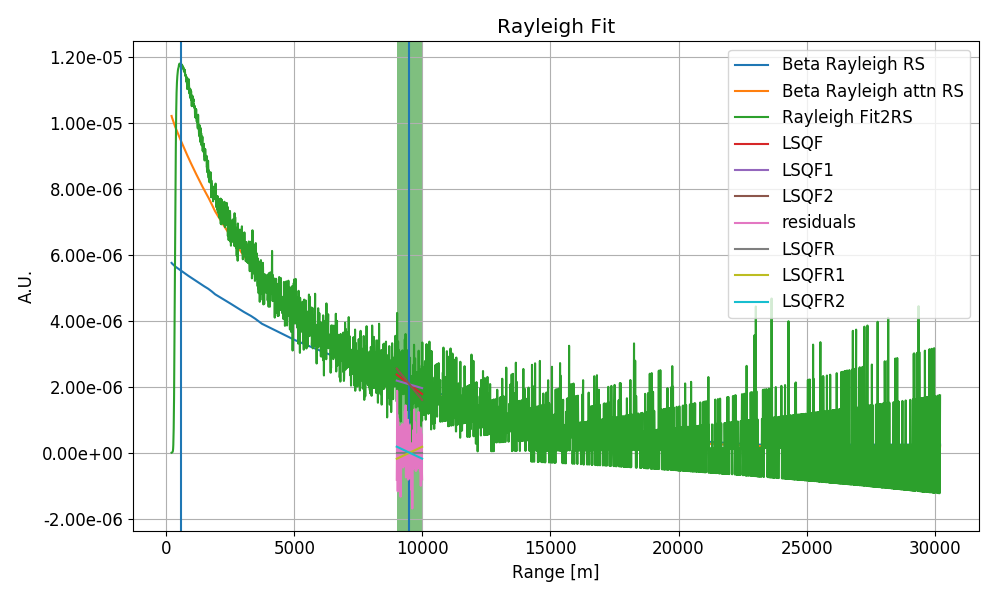

In [42]:
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

plt.plot(hgtRS_int, b_mol_RS[0:len(hgtRS_int)], label = 'Beta Rayleigh RS')
plt.plot(hgtRS_int, b_attn_RS[0:len(hgtRS_int)], label = 'Beta Rayleigh attn RS')
plt.plot(hgtRS_int, ray_RS[0:len(hgtRS_int)], label = 'Rayleigh Fit2RS')

plt.grid()
plt.axvline(x=z[Xp])
plt.axvline(x=hgtRS_int[r0])
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.axvspan(hgtRS_int[0] + rmin * 7.5, hgtRS_int[0] + rmax * 7.5, facecolor='g', alpha=0.5)
#plt.show()

plt.plot(hgtRS_int[rmin:rmax], LSQF, label = 'LSQF')
plt.plot(hgtRS_int[rmin:rmax], LSQF1, label = 'LSQF1')
plt.plot(hgtRS_int[rmin:rmax], LSQF2, label = 'LSQF2')
plt.plot(hgtRS_int[rmin:rmax], residuals, label = 'residuals')
plt.plot(hgtRS_int[rmin:rmax], LSQFR, label = 'LSQFR')
plt.plot(hgtRS_int[rmin:rmax], LSQFR1, label = 'LSQFR1')
plt.plot(hgtRS_int[rmin:rmax], LSQFR2, label = 'LSQFR2')

plt.legend(loc='upper right')
plt.title('Rayleigh Fit')
plt.xlabel('Range [m]')
plt.ylabel('A.U.')
plt.tight_layout()
plt.show()
#plt.close()

In [43]:
lidar_site = 'station ID = bgd (Belgrade)\n'
lidar_name = 'system = BARLI\n'
channel = 'signal = 0387, glued\n'
date = 'date of measurement, time, duration of measurement = 21.02.2019, 0120UTC, 1800s\n'
radiosonde = 'location, WMO radiosonde station ID, date of radiosonde = Belgrade - Kostutnjak, 13275, 21.02.2019, 00UTC\n'
fit_range = 'lower and upper Rayleigh height limits[km]: ' + str(rminm/1000.0) + ', ' + str(rmaxm/1000.0) + '\n'
columns = 'range, attenuated_RayleighBSC, RangeCorrectedSignal'
header = lidar_site + lidar_name + channel + date + radiosonde + fit_range + columns
out_h = hgtRS_wt[28:]
out_b = attnRBSC[28:]
out_g = glued[28:len(hgtRS_wt)]
np.savetxt('ray387.txt', np.column_stack((out_h, out_b, out_g)), fmt='%.15e', header = header, comments='', delimiter=',')